In [2]:
import numpy as np
from pathlib import Path
import table
import tensorflow as tf
import pandas as pd
import re
from tqdm import tqdm
from collections import defaultdict
import keras
from linked_neurons import SeparatingReLU
from keras.models import model_from_json
import dill as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from slugify import slugify



# %load_ext line_profiler

Using TensorFlow backend.


In [3]:
results = None

In [4]:
def extract_metrics(event_file):
    results = []
    for e in tf.train.summary_iterator(event_file):
        for v in e.summary.value:
            if v.tag.endswith('loss') or v.tag.endswith('acc'):
                results.append((e.step, e.wall_time, v.tag, v.simple_value))

    return pd.DataFrame(results, columns=['epoch', 'wall time', 'tag', 'value'])


path = Path('./cifar10_grid_summaries/')

selected_activations = None
architecture_regex = re.compile('-(\d+)x(\d+)-')
sr_regex = re.compile('-sr-(\d+)(?:-(\d+))?(?:(e-\d+))?-')
if not results:
    results = defaultdict(lambda: defaultdict(pd.DataFrame)) # tag, activation
for summary_path in tqdm(path.iterdir(), total=len(list(path.iterdir()))):
    if summary_path.is_dir():
        path = summary_path
        
        event_file = list(path.glob('*events*'))            
        if not event_file:
            print(f'Missing event file at {summary_path}')
        else:
            event_file = str(event_file[0].resolve())
            depth, width = architecture_regex.search(event_file).groups()
            depth, width = int(depth), int(width)
            if 'separating' in event_file:
                match = sr_regex.search(event_file)
                if match is None:
                    continue
                else:
                    integer, decimal, scientific = match.groups()
#                     print(integer, decimal, scientific)
                    if decimal:                        
                        lmda = integer+'.'+decimal 
                    elif scientific:
                        lmda = integer + scientific
                    else:
                        lmda = integer

                    lmda = float(lmda)
                    
                    if 'a-none' in event_file:
                        activation = f'Sep-L {lmda}'
                    elif 'a-0-1' in event_file:
                        activation = f'Sep-UP {lmda}'
                    elif 'a-0' in event_file:
                        activation = f'Sep-U {lmda}'
                    elif 'a-1' in event_file:
                        activation = f'Sep-P {lmda}'

                    else:
                        raise RuntimeError(f'Unknown activation {activation}')

                    if 'zero' in event_file:
                        activation +=' zero'
                    if 'nm-0' in event_file:
                        activation += ' nm-0'
                    if 'ks-3-3' in event_file:
                            activation += ' ks 3x3'

            else:
                if 'relu-bn' in event_file:
                    activation = 'relu-bn'
                else:
                    activation = 'relu'
                if 'ks-3-3' in event_file:
                    activation += ' ks 3x3'
                    
            if not selected_activations or activation in selected_activations:
                try:
                    acc = results['acc'][activation].loc[width, depth]
                    val_acc = results['val_acc'][activation].loc[width, depth]
                    if np.isnan(acc) or np.isnan(val_acc):
#                         print(event_file)

                        metrics = extract_metrics(event_file)
                        best = metrics.groupby('tag').max()['value']

                        results['acc'][activation].loc[width, depth] = best['acc']
                        results['val_acc'][activation].loc[width, depth] = best['val_acc']
                        print(summary_path)

                except KeyError as ex:
#                     print(event_file)
                    metrics = extract_metrics(event_file)
                    best = metrics.groupby('tag').max()['value']

                    results['acc'][activation].loc[width, depth] = best['acc']
                    results['val_acc'][activation].loc[width, depth] = best['val_acc']
                    print(summary_path)

        


            


  0%|          | 0/23 [00:00<?, ?it/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


 30%|███       | 7/23 [00:00<00:00, 62.80it/s]

cifar10_grid_summaries/cifar10-grid-relu-bn-relu-bn-50x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-00-14
cifar10_grid_summaries/cifar10-grid-relu-relu-25x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-54-35
Missing event file at cifar10_grid_summaries/cifar10-grid-separating-relu-separating-relu-50x10-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-20-14-35-10
cifar10_grid_summaries/cifar10-grid-separating-relu-separating-relu-2x10-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-17-42-12
cifar10_grid_summaries/cifar10-grid-relu-relu-50x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-47-00
cifar10_grid_summaries/cifar10-grid-relu-relu-10x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-51-25
cifar10_grid_summaries/cifar10-grid-relu-bn-relu-bn-2x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-

 83%|████████▎ | 19/23 [00:00<00:00, 71.74it/s]

cifar10_grid_summaries/cifar10-grid-separating-relu-separating-relu-25x10-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-17-52-39
cifar10_grid_summaries/cifar10-grid-separating-relu-separating-relu-10x10-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-17-44-46
cifar10_grid_summaries/cifar10-grid-separating-relu-separating-relu-40x10-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-20-15-08-41


100%|██████████| 23/23 [00:00<00:00, 84.77it/s]

cifar10_grid_summaries/cifar10-grid-relu-relu-40x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-08-42
cifar10_grid_summaries/cifar10-grid-relu-relu-30x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-01-04
cifar10_grid_summaries/cifar10-grid-relu-bn-relu-bn-30x10-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-49-26


In [6]:
import dill as pkl
with open('cifar10-results-grid.pkl', 'wb') as f:
    pkl.dump(results , f)
    

In [7]:
import dill as pkl
with open('cifar10-results-grid.pkl', 'rb') as f:
    results = pkl.load(f)

In [8]:
acc = pd.DataFrame()
for metric_name, metric in results.items():
    print(metric_name)
    for activation_name, activation in metric.items():
        if 'ks 3x3' in activation_name:
            print(activation_name)
            print(activation.sort_index().sort_index(axis=1))
    print()
            

acc
relu-bn ks 3x3
        2        10       25       30       40       50       75
10  0.9058  0.81764  0.70496  0.66718  0.59642  0.54744  0.27774
relu ks 3x3
        2        10       25      30      40       50
10  0.7215  0.81618  0.09906  0.0988  0.0981  0.09846
Sep-UP 1e-08 ks 3x3
         2        10       25       30       40
10  0.69264  0.79044  0.74344  0.70452  0.68416

val_acc
relu-bn ks 3x3
        2       10      25      30      40      50      75
10  0.5682  0.5385  0.5414  0.5328  0.4512  0.4159  0.2637
relu ks 3x3
        2       10   25   30   40   50
10  0.5959  0.5974  0.1  0.1  0.1  0.1
Sep-UP 1e-08 ks 3x3
        2       10      25    30     40
10  0.5874  0.5703  0.5353  0.53  0.532



In [9]:
names = {'relu ks 3x3': 'ReLU', 'relu-bn ks 3x3': 'ReLU-BN', 'Sep-UP 1e-08 ks 3x3': 'Sep-UP'}

df_acc = pd.concat(results['acc'])
df_acc = df_acc.iloc[[1,2,0], :-2]
df_acc.index = df_acc.index.droplevel(1)
df_acc = df_acc.rename(index=names)

df_val_acc = pd.concat(results['val_acc'])
df_val_acc = df_val_acc.iloc[[1,2,0], :-2]
df_val_acc.index = df_val_acc.index.droplevel(1)
df_val_acc = df_val_acc.rename(index=names)

df_val_acc

,2,10,25,30,40
ReLU,0.5959,0.5974,0.1000,0.1000,0.1000
ReLU-BN,0.5682,0.5385,0.5414,0.5328,0.4512
Sep-UP,0.5874,0.5703,0.5353,0.5300,0.5320


In [114]:
df_val_acc.to_latex('cifar10_val_acc.tex')
df_acc.to_latex('cifar10_acc.tex')

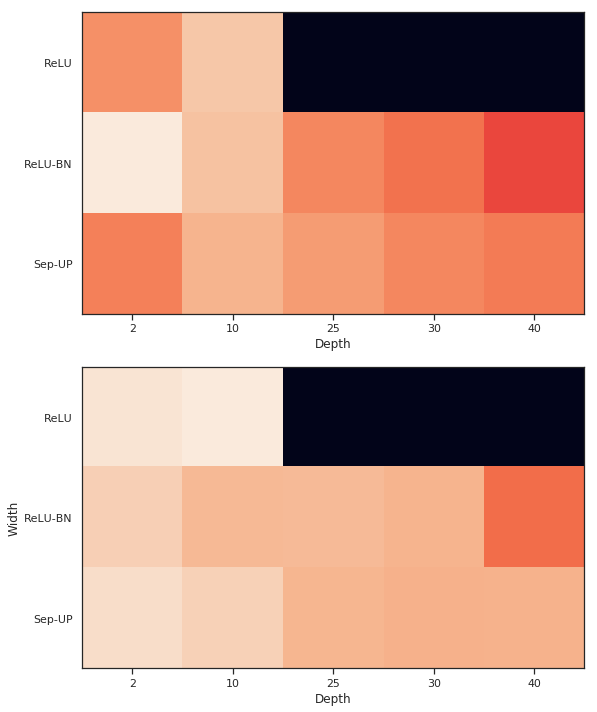

In [115]:
sns.set_style("white")
fig, axes = plt.subplots(2, figsize=(55, 10))
# axes[0].set_title('acc')
# axes[1].set_title('val acc')

vmin = None
vmax = None

axes = axes.flatten()

ax = axes[0]
ax.matshow(df_acc, vmin=vmin, vmax=vmax)
# ax.set_title(f'{metric_name}: {activation_name}')
ax.set_xticks(range(len(df_acc.columns)))
ax.set_yticks(range(len(df_acc.index)))
ax.set_xticklabels(df_acc.columns)
ax.set_yticklabels(df_acc.index)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Depth')

ax = axes[1]
ax.matshow(df_val_acc, vmin=vmin, vmax=vmax)
# ax.set_title(f'{metric_name}: {activation_name}')
ax.set_xticks(range(len(df_val_acc.columns)))
ax.set_yticks(range(len(df_val_acc.index)))
ax.set_xticklabels(df_val_acc.columns)
ax.set_yticklabels(df_val_acc.index)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Depth')
ax.set_ylabel('Width')

fig.tight_layout()

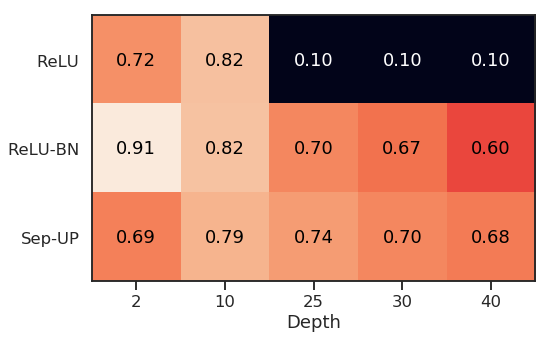

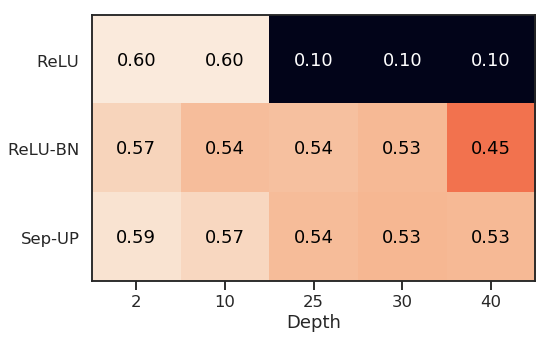

In [15]:
sns.set_style("white")
sns.set_context("talk")

output_dir = Path('plots/cifar10_grid')
output_dir.mkdir(parents=True, exist_ok=True)
font = {
#         'weight' : 'bold',
    'color': 'white'
#         'size'   : 22
}
thr = 0.2

# axes[0].set_title('acc')
# axes[1].set_title('val acc')
vmin = None
vmax = None
# vmin = df_val_acc.min().min()
# vmax = df_val_acc.max().max()

figsize = (8, 5)

fig, ax = plt.subplots(1, figsize=figsize)
ax.matshow(df_acc, vmin=vmin, vmax=vmax)
# ax.set_title(f'{metric_name}: {activation_name}')
ax.set_xticks(range(len(df_acc.columns)))
ax.set_yticks(range(len(df_acc.index)))
ax.set_xticklabels(df_acc.columns)
ax.set_yticklabels(df_acc.index)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Depth')

for (i, j), z in np.ndenumerate(df_acc):
    if z < thr:
        font['color'] = 'white'
    else:
        font['color'] = 'black'
        
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontdict=font)

fig.tight_layout()    
fig.savefig(output_dir.joinpath('cifar10-acc.pdf'))


fig, ax = plt.subplots(1, figsize=figsize)
ax.matshow(df_val_acc, vmin=vmin, vmax=vmax)
# ax.set_title(f'{metric_name}: {activation_name}')
ax.set_xticks(range(len(df_val_acc.columns)))
ax.set_yticks(range(len(df_val_acc.index)))
ax.set_xticklabels(df_val_acc.columns)
ax.set_yticklabels(df_val_acc.index)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Depth')

for (i, j), z in np.ndenumerate(df_val_acc):
    if z < thr:
        font['color'] = 'white'
    else:
        font['color'] = 'black'
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontdict=font)

fig.tight_layout()
fig.savefig(output_dir.joinpath('cifar10-val_acc.pdf'))

